In [180]:
from matplotlib import pyplot as plt
from scipy.stats import multinomial,gamma,dirichlet,poisson
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.special import psi  
from scipy.special import digamma, gammaln

In [181]:
class CAVI():
    def __init__(self, data,pi_a,gamma_a,gamma_b,K):

        # Number of Topics
        self.K = K

        # For Data & Size
        self.data = data
        self.N, self.V = data.shape

        # For PI (PI ~ Dirichlet)
        self.pi_a = pi_a

        # For Lambda (Lambda ~ Gamma)
        self.gamma_a = gamma_a
        self.gamma_b = gamma_b

        self.elbo = []

    def init_params(self):
        self.pis = [self.pi_a] * self.K
        self.pis = self.pis / np.sum(self.pis)
        self.lambdas = gamma.rvs(self.gamma_a, 1 / self.gamma_b, size=(self.K,self.V))
        self.Z = np.zeros((self.N, self.K))
        for i in range(self.N):
            self.Z[i] = multinomial.rvs(n=1, p=self.pis)
        self.expected_counts = np.dot(self.Z.T, self.data)
        print('----initialize random variables finished----')
        #print(f'PIS: {self.pis}, Lambdas: {self.lambdas}, Z:{self.Z}')

    def update(self):
        
        self.update_z()
        self.expected_counts = np.dot(self.Z.T, self.data)
        self.update_pi()
        self.update_lambda()
        
        #for k in range(self.K):
        #    print(self.lambdas[k])
        #print('----update parameters finished----')
        
    
    def update_pi(self):
        self.pis = np.sum(self.Z, axis=0) + self.pi_a
        self.pis = self.pis / np.sum(self.pis)
    
    def update_lambda(self):
        for k in range(self.K):
            self.lambdas[k] = (self.expected_counts[k] + self.gamma_a) / (self.gamma_b + np.sum(self.Z[:, k]))
            #print(self.expected_counts[k],np.sum(self.Z[:, k]))

    def update_z(self):
        for i in range(self.N):  # for each document
            self.Z[i] = np.exp(psi(self.pis) + np.dot(self.data[i], (psi(self.lambdas.T) - np.log(self.lambdas.T))))
            self.Z[i] /= np.sum(self.Z[i])  # normalize
        self.Z = np.eye(self.Z.shape[1])[np.argmax(self.Z, axis=1)]
     

    def calculate_elbo(self):
        expected_log_likelihood = self.compute_log_likelihood()
        expected_entropy = self.compute_entropy()
        # print(f'expected_log_likelihood: {expected_log_likelihood}, expected_entropy: {expected_entropy}')
        return expected_log_likelihood - expected_entropy
    
    
    
    def compute_log_likelihood(self):
        lnpx = np.sum(np.dot(self.data, np.log(np.dot(self.Z, self.lambdas)).T))
        lnpZ = np.sum(np.dot(self.lambdas.T, np.log(self.pis)))
        lnppi = np.log(self.pi_a) + np.sum((self.pi_a - 1) * np.log(self.pis))
        lnplambda = np.sum((self.gamma_a - 1) * np.log(self.lambdas) - self.gamma_b * self.lambdas)
        return lnpx + lnpZ + lnppi + lnplambda

        # exp_poisson = np.sum(poisson.logpmf(self.data,np.dot(self.Z,self.lambdas)))
        # exp_gamma = np.sum(gamma.logpdf(self.lambdas, self.gamma_a, scale= 1/self.gamma_b))
        # exp_multinomial = np.sum(multinomial.logpmf(self.Z, n=1, p=self.pis))
        # #print(f'{self.pis}')
        # exp_dirichlet = dirichlet.logpdf(self.pis, np.ones(self.K)*self.pi_a)
        # # print(f'exp_poisson: {exp_poisson}, exp_gamma: {exp_gamma}, exp_multinomial: {exp_multinomial}, exp_dirichlet: {exp_dirichlet}')
        # return exp_poisson + exp_multinomial + exp_dirichlet + exp_gamma
        
    
    def compute_entropy(self):
        lnqz = np.sum(np.dot(self.lambdas, np.log(self.lambdas).T))
        lnqpi = np.log(self.pi_a) + np.sum((self.pis - 1) * np.log(self.pis))
        lnqlambda = np.sum((self.gamma_a - 1) * np.log(self.lambdas) - self.gamma_b * self.lambdas)
        
        # print(f'lnqz: {lnqz}, lnqpi: {lnqpi}, lnqlambda: {lnqlambda}')
        return lnqz + lnqpi + lnqlambda
        # exp_log_q_Z = np.sum(multinomial.logpmf(self.Z, n=1, p=self.pis))
        # exp_log_q_pi = dirichlet.logpdf(self.pis, np.ones(self.K)*self.pi_a)
        # exp_log_q_lambda = np.sum(gamma.logpdf(self.lambdas, self.gamma_a, scale=1/self.gamma_b))
        # return exp_log_q_Z + exp_log_q_pi + exp_log_q_lambda

    def fit(self, max_iter=100):
        self.init_params()
        print('----start iteration----')
        for i in tqdm(range(max_iter),total=max_iter,desc='VI',ncols=100,ascii=' =',leave=True):
            self.update()
            self.elbo.append(self.calculate_elbo())
            if (len(self.elbo) >= 50) and (np.abs(self.elbo[-1] - self.elbo[-2]) < 1e-7):
                print(i)
                break
        print('----finish iteration----')


In [182]:
data = pd.DataFrame()
vocabs = []
with open('./vocab.txt', 'r') as f:
    for line in f:
        vocabs.append(line.split()[0])

rows = []
count = []
with open('./ap.dat', 'r') as f:
    for line in f:
        tmp = line.split(' ')
        count.append(tmp[0])
        tmp = tmp[1:]
        row = [0] * len(vocabs)
        for elem in tmp:
            index, value = elem.split(':')
            row[int(index)] = int(value)
        rows.append(row)
            
x_data = pd.DataFrame(rows, columns = vocabs)

In [183]:
vocabs = []
with open('./vocab.txt', 'r') as f:
    for line in f:
        vocabs.append(line.strip())
        
tmp = x_data.sum()
tmp = np.array(tmp)
to_be_pruned = []
for idx, elem in enumerate(tmp):
    if elem > 1000 or elem < 10:
        to_be_pruned.append(idx)

for i in sorted(to_be_pruned, reverse=True):
    del vocabs[i]
    
pruned_x = x_data[vocabs]

In [184]:
pruned_x.sum()

officials      1000
soviet          999
united          998
bush            949
time            948
               ... 
chicken          10
homosexuals      10
rocked           10
locate           10
frohnmayer       10
Length: 7262, dtype: int64

In [185]:
gamma_a = 1
gamma_b = 2
pi_a = 0.1
K = 8

In [186]:
# cavi = CAVI(data=x_data.values,pi_a=pi_a,gamma_a=gamma_a,gamma_b=gamma_b,K=K)
cavi = CAVI(data=pruned_x.values,pi_a=pi_a,gamma_a=gamma_a,gamma_b=gamma_b,K=K)

In [187]:
cavi.fit(max_iter=100)

----initialize random variables finished----
----start iteration----


VI:   1%|                                                           | 1/100 [00:02<04:50,  2.93s/it]/tmp/ipykernel_258491/3756073649.py:55: RuntimeWarning: invalid value encountered in divide
  self.Z[i] /= np.sum(self.Z[i])  # normalize
VI:  49%|============================                              | 49/100 [01:54<01:59,  2.34s/it]

49
----finish iteration----


In [188]:
cavi.lambdas.shape

(8, 7262)

In [189]:
top_word_index = {}
for idx, ld in enumerate(cavi.lambdas):
    top_word_index[idx] =  sorted(range(len(ld)), key=lambda x: ld[x])[-30:]
    top_word_index[idx].reverse()

toplist = pd.DataFrame()
for topic in top_word_index:
    # print(f"Topic K={topic}:   ", )
    tmp =[]
    for idx in top_word_index[topic]:
        tmp.append(vocabs[idx])
    toplist[topic] = tmp

In [190]:
toplist

,0,1,2,3,4,5,6,7
0,soviet,frohnmayer,points,billboard,agency,frohnmayer,monday,reported
1,united,locate,stock,inc,news,locate,cigarettes,department
2,officials,rocked,index,weeks,reported,rocked,test,spokesman
3,bush,homosexuals,exchange,today,friday,homosexuals,commission,communist
4,time,chicken,share,magazine,contract,chicken,american,north
5,three,bankrupt,shares,king,accident,bankrupt,editors,report
6,billion,wishes,financial,stamps,bush,wishes,executed,party
7,today,hinted,average,publications,officials,hinted,trades,friday
8,told,lengthy,times,copyright,hunter,lengthy,eastern,n
9,national,rid,closed,permission,india,rid,director,carolina


In [191]:
pruned_x

,officials,soviet,united,bush,time,three,billion,today,national,told,...,rid,lengthy,hinted,wishes,bankrupt,chicken,homosexuals,rocked,locate,frohnmayer
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,2,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,2,1,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,0,0,0,0,0,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
2242,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2243,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2244,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [192]:
documents = []

for doc_vector in pruned_x.values:
    document = []
    for word_idx, count in enumerate(doc_vector):
        document += [vocabs[word_idx]]*count
    documents.append(document)

In [193]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

dictionary = Dictionary(documents)

topics = toplist.values.tolist()

cm = CoherenceModel(topics=topics, dictionary=dictionary, texts=documents, coherence='c_v')

print('Coherence Score: ', cm.get_coherence())

Coherence Score:  0.27931785773568785


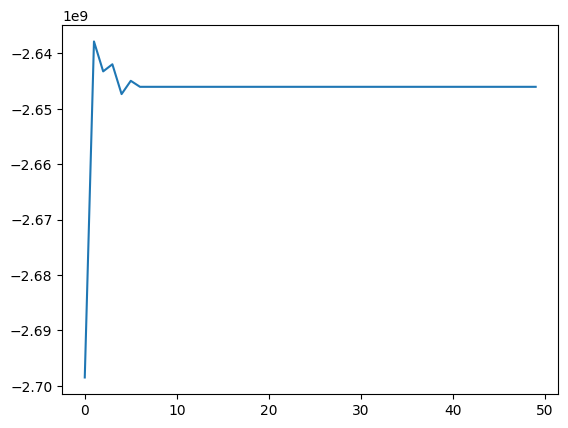

In [194]:
plt.plot(cavi.elbo)